# Soft-sensing with linear models [1]

# 1. Bivariate case

In an article published recently, we suggested using the probabilistic principal component analysis (PPCA) model instead of the standard principal component analysis (PCA) model to determine the number of components for data dimension reduction [1]. The article is focused on methods to determine the number of components. However, several of the studied methods are based on data imputation. These data imputation methods can be used as soft-sensors, i.e. to estimate an unmeasured variable. Soft-sensors can also be used to estimate the values of missing data, typically assuming that the imputed values are missing completely at random (MCAR) [2]. The article length did not allow to check the performance of the data imputation methods themselves. This and the next post give a peek into that. Three models are used for this purpose: linear regression (LR), PCA, and PPCA. 
In this post, I will test the selected soft-sensor models for a simple case with two variables ($N=2$), i.e. with one input and one output. The notebook used to create this post is available on [GitLab](https://gitlab.com/krisvillez/software-sensors).

#### What is a soft-sensor?

A soft-sensor is any system or device that computes a variable of interest (the target) that is not measured directly or only with delay. This is achieved by means of a model describing the relationship of the target with other variables that can be measured momentarily (the inputs). Many standard sensors are actually soft-sensors even if we usually don't think of them as such. For example, an ion-selective pH sensor computes the value of the pH on the basis of the Nernst equation. This equation is a model with parameters that are estimated to predict the pH (output) to a measured electrode potential and temperature (inputs). The parameters are usually kept up-to-date through calibration.


## 1.1. Toy example

The next figure shows data for an idealized pH sensor where the measured electrode potential (input) will be used to predict the pH (output), assuming constant temperature. We simulate measurements of the input and output and subject both of these to Gaussian measurement noise. For simplicity, the standard deviations describing the noise are considered known. Note that the true values are sampled from a Gaussian distribution also. The calibration and test data (with measurement error) are shown in blue and black. The relationship between the true values (without measurement error) is shown as a grey line. Note how different symbols are used to distinguish between the true values ($x, y$) and the measured values ($\tilde{x}$, $\tilde{y}$)

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from scipy.stats import norm
from scipy.stats import pearsonr

In [2]:
np.random.seed(42)

# Parameters
Sens = 59.16 # mV/pNH3
yo = 7
xo = 0
sigma_y = 0.05
sigma_x = 15

# Simulate calibration data
N_cal =256 
y_cal = np.random.normal(0, 0.25, N_cal)
y_cal = 5.5+np.sort(y_cal)*2
x_cal = xo-Sens*(y_cal-yo)
xtil_cal = x_cal+sigma_x*np.random.normal(0,1,N_cal)
ytil_cal = y_cal+sigma_y*np.random.normal(0,1,N_cal)

# Simulate test data
N_test = 1024 
y_test = np.random.normal(0, 0.25, N_test)
y_test = 5.5+np.sort(y_test)*2
x_test = xo-Sens*(y_test-yo)
xtil_test = x_test+sigma_x*np.random.normal(0,1,N_test)
ytil_test = y_test+sigma_y*np.random.normal(0,1,N_test)

In [3]:
# relationship between true variables
X = np.concatenate([np.ones(N_cal)[:,None],x_cal[:,None]],axis=1)
Xbar = np.linalg.pinv(X)
beta = np.dot(Xbar,y_cal)

# Visualization
x_sim = np.array([-15,195])

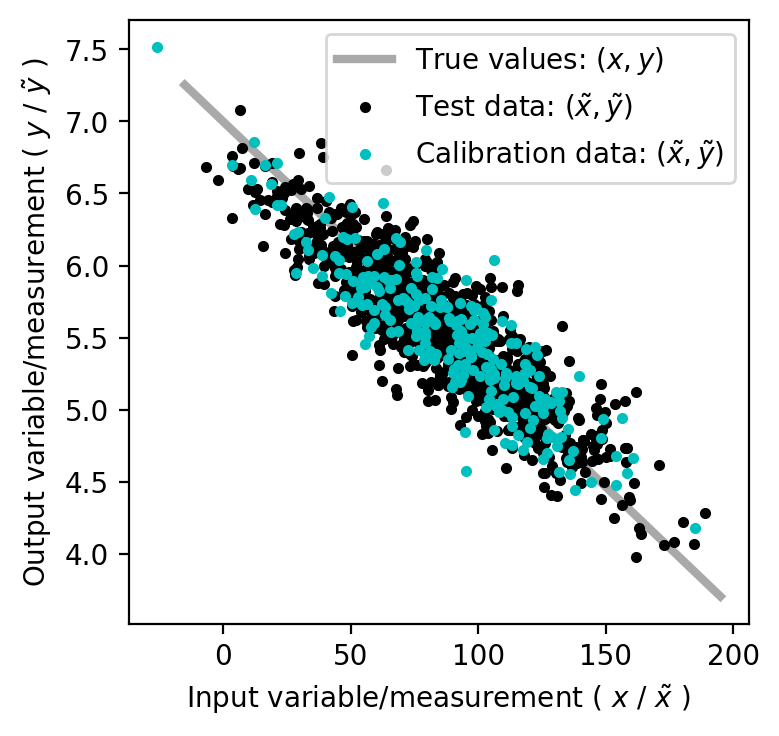

In [4]:
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=[4,4],dpi=200)
ax.plot( x_sim,beta[1]*x_sim+beta[0],'-',lw=3,color='darkgrey',label='True values: $(x,y)$')
ax.plot( xtil_test,ytil_test,'k.',label='Test data: $(\~{x},\~{y})$')
ax.plot( xtil_cal,ytil_cal,'c.',label='Calibration data: $(\~{x},\~{y})$')
ax.legend()
ax.set_xlabel('Input variable/measurement ( $x$ / $\~x$ )')
ax.set_ylabel('Output variable/measurement ( $y$ / $\~y$ )');

## 1.2. Tested models for soft-sensing

There is nothing particularly restrictive or special about models used for soft-sensing. Any model describing a relationship between two or more variables can be used for soft-sensing. In these posts, I will focus on models that describe a linear relationship between the two variables. These are the tested models:

* Linear regression (LR). Standard linear regression, meaning that the output variable (pH) is considered to be subject to measurement error and that the input variable (potential) is assumed to be measured perfectly (no measurement error).

* Principal component analysis (PCA). PCA is a standard approach to dimension reduction and can be used for imputation also. We assume to scale the measurements with the (known) measurement error standard deviation. This means the obtained PCA model corresponds to maximum Likelihood Principal Component Analysis (MLPCA) [3-4]. The number of components is set equal to one ($K=1$) because the purpose of the model is to estimate the value of one variable with measurements of the other, which is infeasible with the alternative options (i.e., $K=0$, $K=2$). The predicted value is obtained through projection to the model plane (PMP) [5], one of many methods that can be used for PCA-based data imputation [6]. 

* Probabilistic principal component analysis (PPCA). This is a probabilistic version of PCA, which requires an additional assumption, namely that the joint distribution of all data is a (multivariate) normal distribution [7]. This model is also equivalent to sensible principal component analysis (SPCA) [8]. As with PCA, the number of components is set equal to one ($K=1$) although this is not strictly necessary in this case. We scale the measurements with the (known) measurement error standard deviation again.

## 1.3. Model identification and use

### 1.3.1. Model Calibration

The next plot shows the calibration data and the modelled relationship in red for each of the three models. For the LR model this is simply the regression line. For the PCA and PPCA models, this is the line described by the first principal component. One can see that the LR model deviates substantially from the data-generating model. In contrast, PCA and PPCA deliver a model that is much closer to the data-generating model. This is explained easily: both PCA and PPCA are based on correct assumptions about the measurement errors and their standard deviations, whereas the LR model implies that the input variable is measured without measurement error.

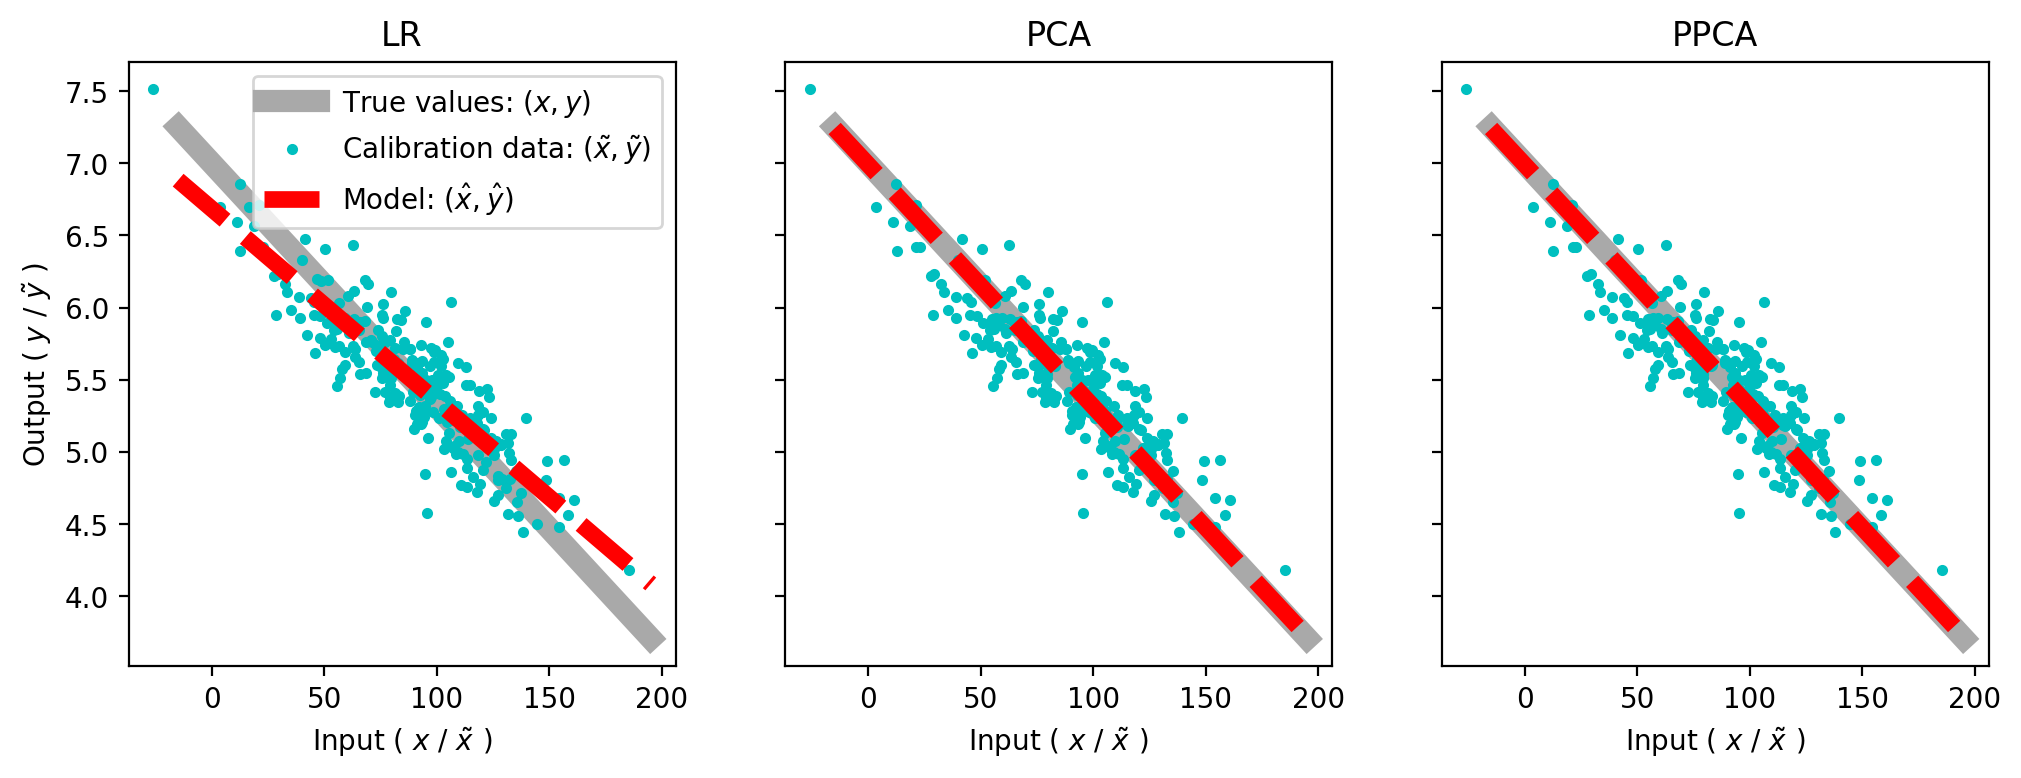

In [5]:
# LR model
Xtil_cal = np.concatenate([np.ones(N_cal)[:,None],xtil_cal[:,None]],axis=1)
betahat_LR = np.dot(np.linalg.pinv(Xtil_cal),ytil_cal)
yhat_LR_sim= betahat_LR[1]*x_sim+betahat_LR[0]

# PCA and PPCA model
Z = np.concatenate([xtil_cal[:,None],ytil_cal[:,None]],axis=1)
zm = np.mean(Z,axis=0)
Zcs = np.divide(Z-zm,[sigma_x,sigma_y])
[U,S,V] = np.linalg.svd(Zcs, full_matrices=True, compute_uv=True, hermitian=False)

betahat_PCA = [-V[1,0]*((-zm[0])/sigma_x)/V[1,1]*sigma_y+zm[1],-V[1,0]/sigma_x/V[1,1]*sigma_y]
yhat_PCA_sim = betahat_PCA[1]*x_sim+betahat_PCA[0]

fig,axs = plt.subplots(nrows=1, ncols=3,figsize=[12,4],dpi=200, sharey='row')
ax = axs[0]
ax.plot( x_sim,beta[1]*x_sim+beta[0],'-',lw=8,color='darkgrey',label='True values: $(x,y)$')
ax.plot( xtil_cal,ytil_cal,'c.',label='Calibration data: $(\~{x},\~{y})$')
ax.plot( x_sim,yhat_LR_sim,'--',lw=6,color='red',label='Model: $(\^x,\^y)$')
ax.set_title('LR')
ax.set_xlabel('Input ( $x$ / $\~x$ )')
ax.set_ylabel('Output ( $y$ / $\~y$ )')
ax.legend()

ax = axs[1]
ax.plot( x_sim,beta[1]*x_sim+beta[0],'-',lw=8,color='darkgrey')
ax.plot( xtil_cal,ytil_cal,'c.')
ax.plot( x_sim,yhat_PCA_sim,'--',lw=6,color='red')
ax.set_title('PCA')
ax.set_xlabel('Input ( $x$ / $\~x$ )')

ax = axs[2]
ax.plot( x_sim,beta[1]*x_sim+beta[0],'b-',lw=8,color='darkgrey')
ax.plot( xtil_cal,ytil_cal,'c.')
ax.plot( x_sim,yhat_PCA_sim,'--',lw=6,color='red')
ax.set_title('PPCA');
ax.set_xlabel('Input ( $x$ / $\~x$ )');

### 1.3.2. Model Testing

The three models are tested for soft-sensing now. We assume to know the input variable (potential) and predict the output variable (pH) with every model. With LR, the predictions lie on the regression line described above. This is not surprising. With PCA, the same happens although the line is different. With PPCA, something rather peculiar happens: the predictions lie on a line that is different from the line described by the first principal component. Moreover, these PPCA-based predictions are the same as those with LR. How odd!

In [6]:
Sigma = np.cov(Z.T) 

betahat_PPCA = [-zm[0]*Sigma[0,1]/Sigma[0,0]+zm[1],Sigma[0,1]/Sigma[0,0]]

# Simulate predictions
yhat_LR_sim = betahat_LR[1]*x_sim+betahat_LR[0]
yhat_PCA_sim = betahat_PCA[1]*x_sim+betahat_PCA[0]
yhat_PPCA_sim = betahat_PPCA[1]*x_sim+betahat_PPCA[0]

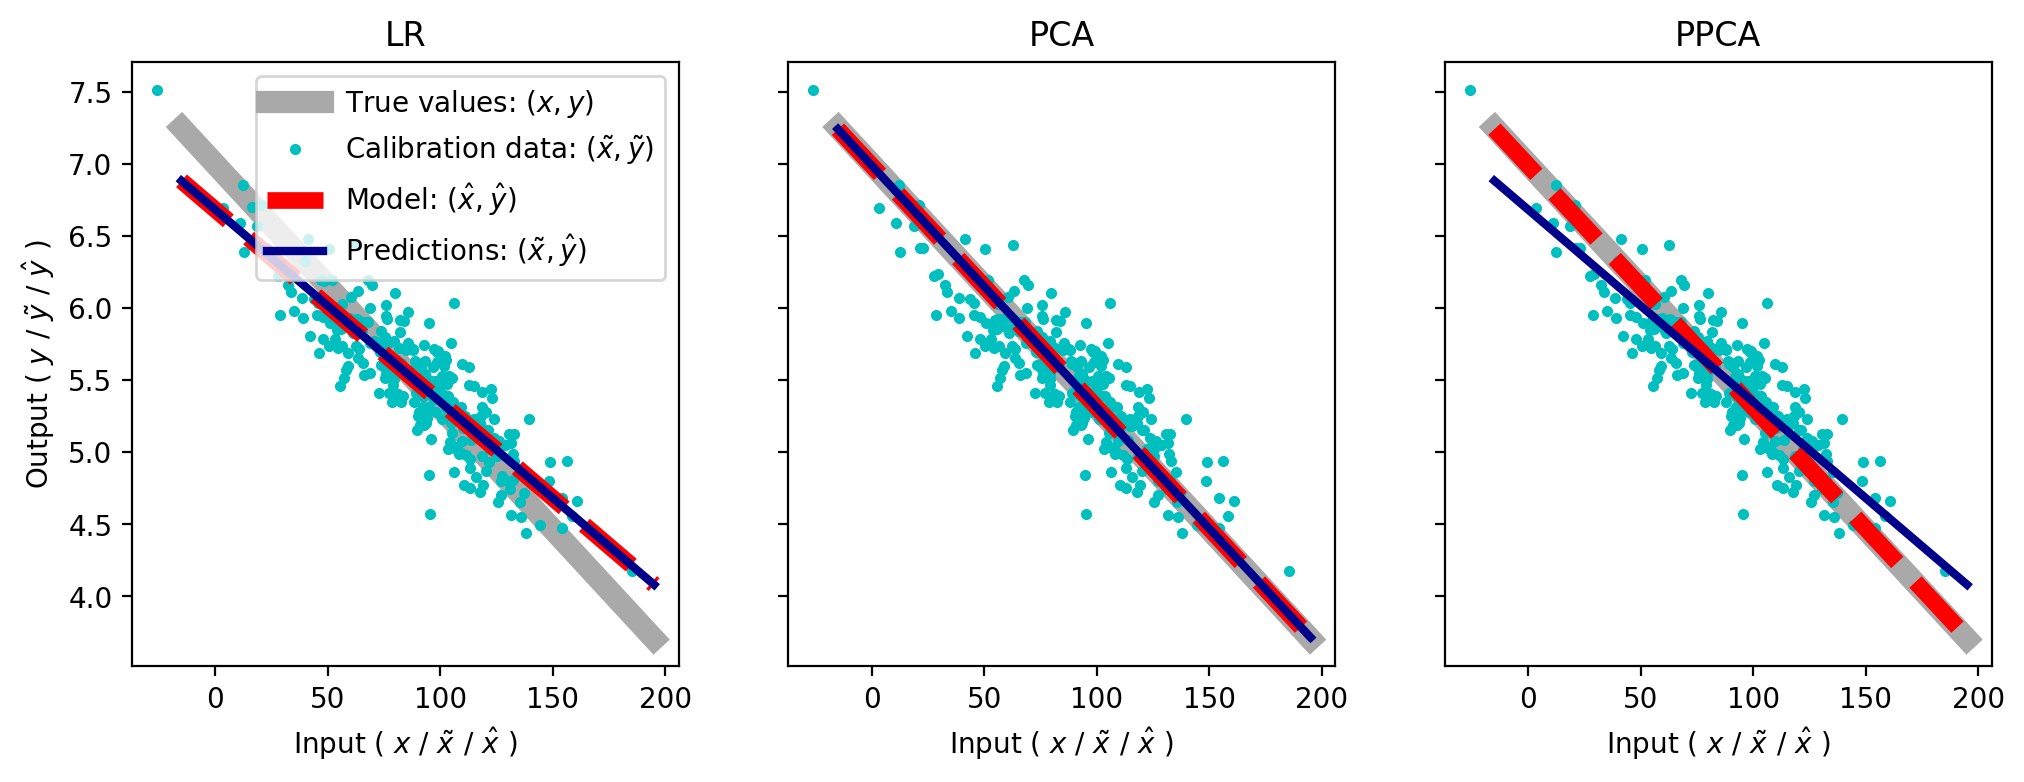

In [7]:
fig,axs = plt.subplots(nrows=1, ncols=3,figsize=[12,4],dpi=200, sharey='row')

ax = axs[0]
ax.plot( x_sim,beta[1]*x_sim+beta[0],'-',lw=8,color='darkgrey',label='True values: $(x,y)$')
ax.plot( xtil_cal,ytil_cal,'c.',label='Calibration data: $(\~{x},\~{y})$')
ax.plot( x_sim,yhat_LR_sim,'--',lw=6,color='red',label='Model: $(\^x,\^y)$')
ax.plot( x_sim,yhat_LR_sim,'-',lw=3,color='darkblue',label='Predictions: $(\~x,\^y)$')
ax.set_title('LR')
ax.set_xlabel('Input ( $x$ / $\~x$ / $\^x$ )');
ax.set_ylabel('Output ( $y$ / $\~y$ / $\^y$ )')
ax.legend()

ax = axs[1]
ax.plot( x_sim,beta[1]*x_sim+beta[0],'k-',lw=8,color='darkgrey')
ax.plot( xtil_cal,ytil_cal,'c.')
ax.plot( x_sim,yhat_PCA_sim,'--',lw=6,color='red')
ax.plot( x_sim,yhat_PCA_sim,'-',lw=3,color='darkblue')
ax.set_title('PCA')
ax.set_xlabel('Input ( $x$ / $\~x$ / $\^x$ )');

ax = axs[2]
ax.plot( x_sim,beta[1]*x_sim+beta[0],'k-',lw=8,color='darkgrey')
ax.plot( xtil_cal,ytil_cal,'c.')
ax.plot( x_sim,yhat_PCA_sim,'--',lw=6,color='red')
ax.plot( x_sim,yhat_PPCA_sim,'-',lw=3,color='darkblue')
ax.set_title('PPCA');
ax.set_xlabel('Input ( $x$ / $\~x$ / $\^x$ )');

## 1.4. Deeper down

### 1.4.1. The PPCA predictions are actually optimal

A further counter-intuitive result is that the PPCA-based predictions (and therefore also the LR-based predictions) are actually optimal. The next plots show the prediction errors (difference between prediction and true value) and the prediction residuals (difference between prediction and measured value) as a function of the predicted value. This is for the independent test data. The PCA-based prediction errors and residuals appear to be correlated with the predictions, suggesting that the predictions should not be trusted. In contrast, the LR- and PPCA-based predictions do not show this correlation. They are also spread in a slightly narrower band.

In [8]:
yhat_LR_test    = betahat_LR[1]*xtil_test+betahat_LR[0]
yhat_PCA_test   = betahat_PCA[1]*xtil_test+betahat_PCA[0]
yhat_PPCA_test  = betahat_PPCA[1]*xtil_test+betahat_PPCA[0]

e_LR_test = yhat_LR_test-y_test
r_LR_test = yhat_LR_test-ytil_test
e_LR_test_mn = np.mean(e_LR_test)
e_LR_test_sd = np.std(e_LR_test)
r_LR_test_mn = np.mean(r_LR_test)
r_LR_test_sd = np.std(r_LR_test)
ecorr_LR_test = pearsonr(yhat_LR_test,e_LR_test)[0]
rcorr_LR_test = pearsonr(yhat_LR_test,r_LR_test)[0]

e_PCA_test = yhat_PCA_test-y_test
r_PCA_test = yhat_PCA_test-ytil_test
e_PCA_test_mn = np.mean(e_PCA_test)
e_PCA_test_sd = np.std(e_PCA_test)
r_PCA_test_mn = np.mean(r_PCA_test)
r_PCA_test_sd = np.std(r_PCA_test)
ecorr_PCA_test = pearsonr(yhat_PCA_test,e_PCA_test)[0]
rcorr_PCA_test = pearsonr(yhat_PCA_test,r_PCA_test)[0]

e_PPCA_test = yhat_PPCA_test-y_test
r_PPCA_test = yhat_PPCA_test-ytil_test
e_PPCA_test_mn = np.mean(e_PPCA_test)
e_PPCA_test_sd = np.std(e_PPCA_test)
r_PPCA_test_mn = np.mean(r_PPCA_test)
r_PPCA_test_sd = np.std(r_PPCA_test)
ecorr_PPCA_test = pearsonr(yhat_PPCA_test,e_PPCA_test)[0]
rcorr_PPCA_test = pearsonr(yhat_PPCA_test,r_PPCA_test)[0]

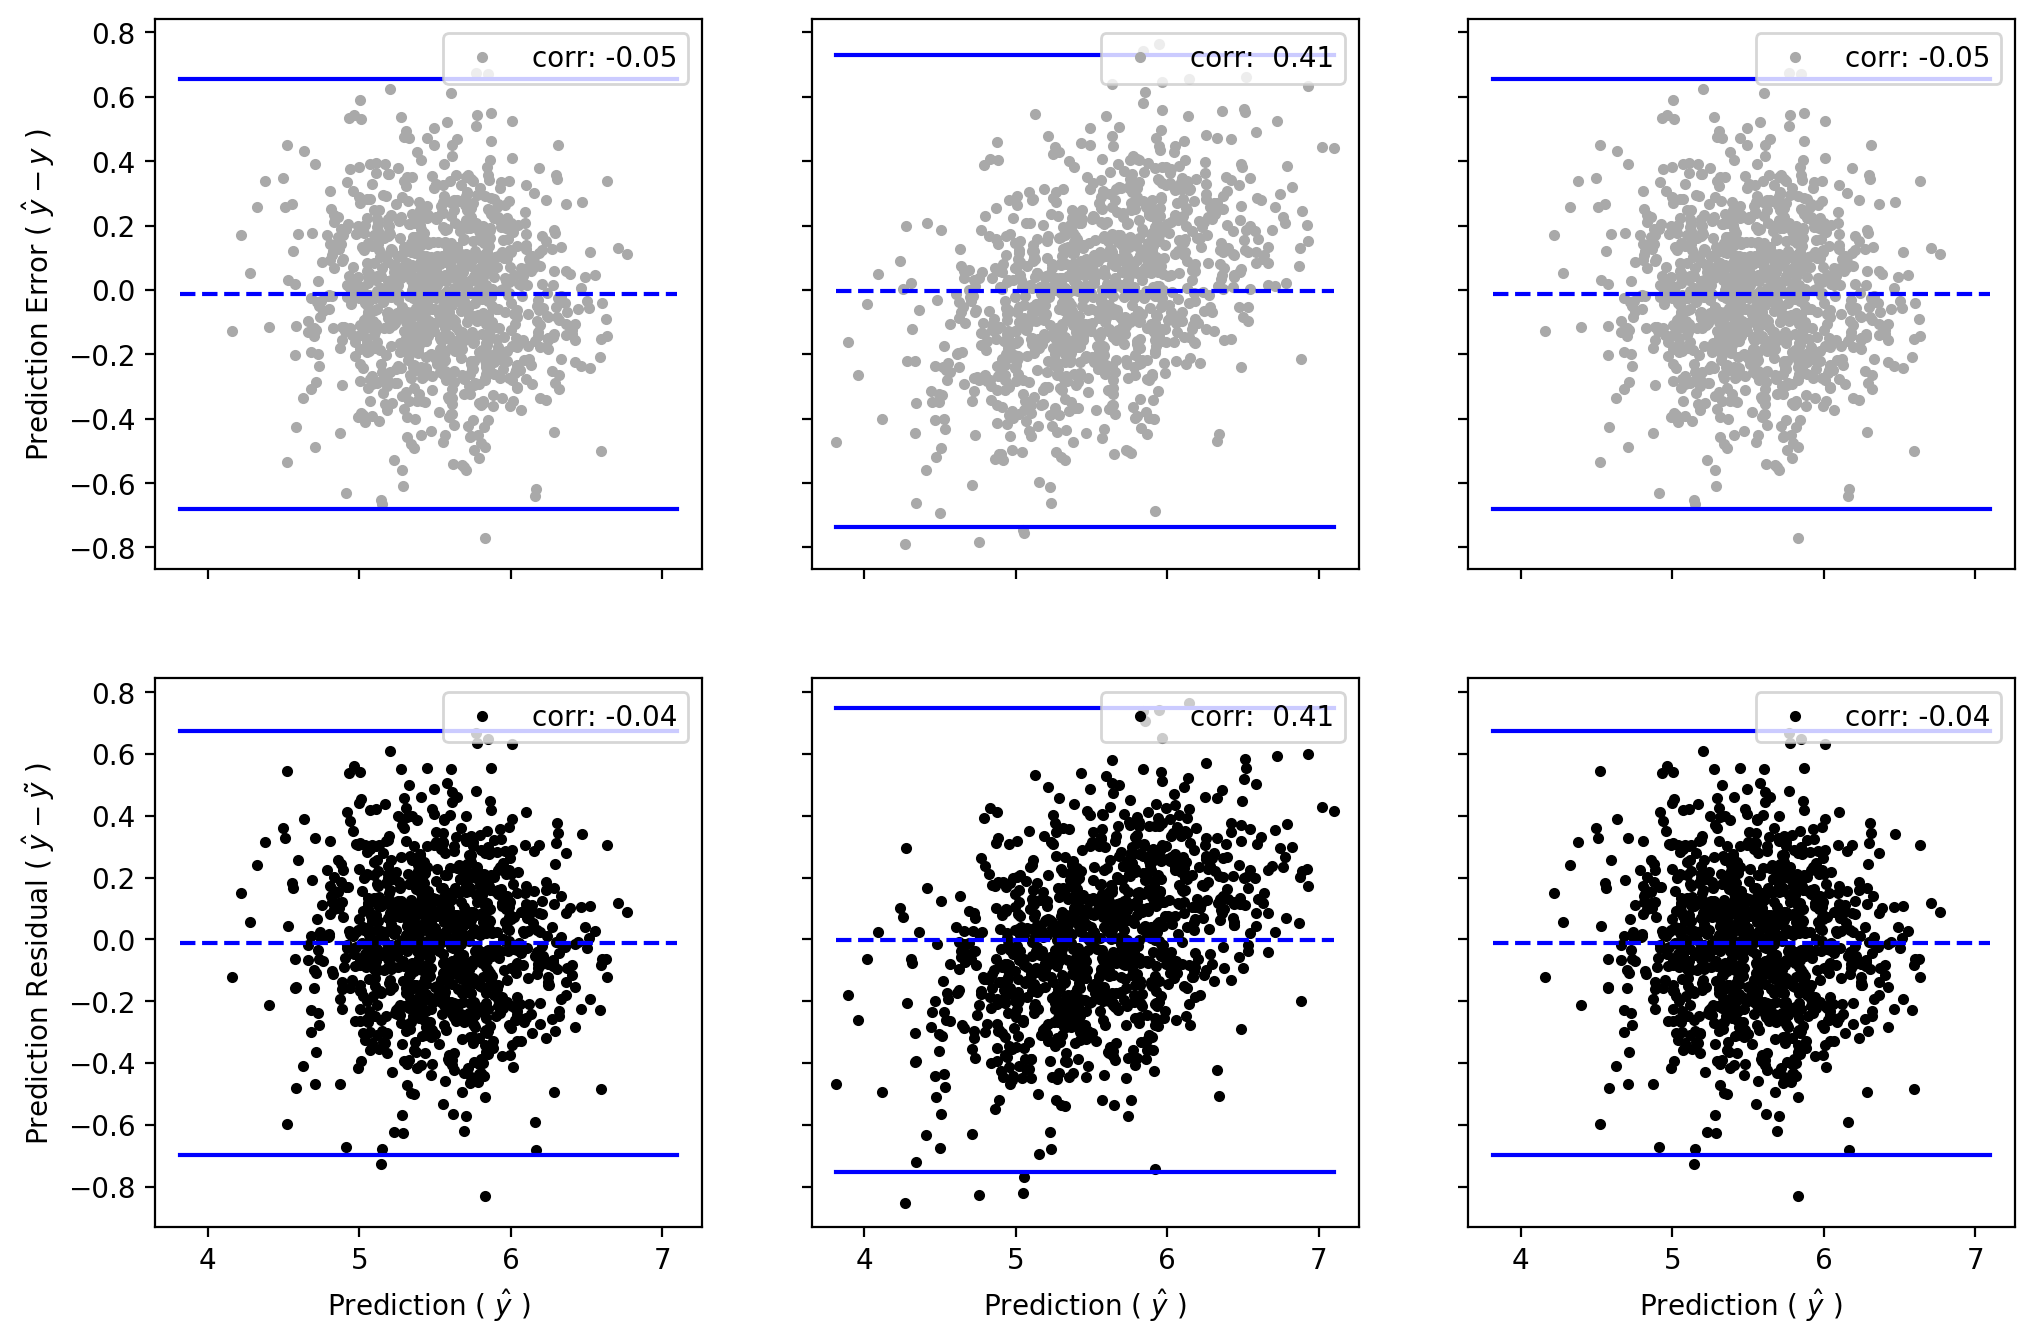

In [9]:

ymin = np.min([yhat_LR_test,yhat_PCA_test,yhat_PPCA_test])
ymax = np.max([yhat_LR_test,yhat_PCA_test,yhat_PPCA_test])

fig,axs = plt.subplots(nrows=2, ncols=3,figsize=[12,8],dpi=200, sharex='col', sharey='row') #
ax = axs[0,0]
ax.plot(yhat_LR_test,e_LR_test,'.',color='darkgrey',label='corr:{:6.2f}'.format(ecorr_LR_test))
ax.plot([ymin,ymax],+e_LR_test_mn*np.ones(2),'b--')
ax.plot([ymin,ymax],+e_LR_test_mn*np.ones(2)+3*e_LR_test_sd,'b-')
ax.plot([ymin,ymax],+e_LR_test_mn*np.ones(2)-3*e_LR_test_sd,'b-')
ax.set_ylabel('Prediction Error ( $\^y-y$ )');
ax.legend(loc=1)
ax = axs[1,0]
ax.plot(yhat_LR_test,r_LR_test,'k.',label='corr:{:6.2f}'.format(rcorr_LR_test))
ax.plot([ymin,ymax],+r_LR_test_mn*np.ones(2),'b--')
ax.plot([ymin,ymax],+r_LR_test_mn*np.ones(2)+3*r_LR_test_sd,'b-')
ax.plot([ymin,ymax],+r_LR_test_mn*np.ones(2)-3*r_LR_test_sd,'b-')
ax.set_xlabel('Prediction ( $\^y$ )');
ax.set_ylabel('Prediction Residual ( $\^y-\~y$ )');
ax.legend(loc=1)

ax = axs[0,1]
ax.plot(yhat_PCA_test,e_PCA_test,'.',color='darkgrey',label='corr:{:6.2f}'.format(ecorr_PCA_test))
ax.plot([ymin,ymax],+e_PCA_test_mn*np.ones(2),'b--')
ax.plot([ymin,ymax],+e_PCA_test_mn*np.ones(2)+3*e_PCA_test_sd,'b-')
ax.plot([ymin,ymax],+e_PCA_test_mn*np.ones(2)-3*e_PCA_test_sd,'b-')
ax.legend(loc=1)
ax = axs[1,1]
ax.plot(yhat_PCA_test,r_PCA_test,'k.',label='corr:{:6.2f}'.format(rcorr_PCA_test))
ax.plot([ymin,ymax],+r_PCA_test_mn*np.ones(2),'b--')
ax.plot([ymin,ymax],+r_PCA_test_mn*np.ones(2)+3*r_PCA_test_sd,'b-')
ax.plot([ymin,ymax],+r_PCA_test_mn*np.ones(2)-3*r_PCA_test_sd,'b-')
ax.set_xlabel('Prediction ( $\^y$ )');
ax.legend(loc=1)

ax = axs[0,2]
ax.plot(yhat_PPCA_test,e_PPCA_test,'.',color='darkgrey',label='corr:{:6.2f}'.format(ecorr_PPCA_test))
ax.plot([ymin,ymax],+e_PPCA_test_mn*np.ones(2),'b--')
ax.plot([ymin,ymax],+e_PPCA_test_mn*np.ones(2)+3*e_PPCA_test_sd,'b-')
ax.plot([ymin,ymax],+e_PPCA_test_mn*np.ones(2)-3*e_PPCA_test_sd,'b-')
ax.legend(loc=1)
ax = axs[1,2]
ax.plot(yhat_PPCA_test,r_PPCA_test,'k.',label='corr:{:6.2f}'.format(rcorr_PPCA_test))
ax.plot([ymin,ymax],+r_PPCA_test_mn*np.ones(2),'b--')
ax.plot([ymin,ymax],+r_PPCA_test_mn*np.ones(2)+3*r_PPCA_test_sd,'b-')
ax.plot([ymin,ymax],+r_PPCA_test_mn*np.ones(2)-3*r_PPCA_test_sd,'b-')
ax.set_xlabel('Prediction ( $\^y$ )');
ax.legend(loc=1)

plt.show()

### 1.4.2 Why are the PPCA predictions optimal?

To understand the strange behaviour of the PPCA-based predictions, it is key to note that the PPCA model, unlike PCA, models a full covariance matrix and does not reduce the number of dimensions. Instead, the PPCA model replaces the last ($N-K$) eigenvalues of the covariance matrix with their average. In the simple bivariate setting it holds that $N-K=1$. As a result, the eigenvalues are unmodified. Following identification of the covariance matrix, the PPCA-based predictions are equal to the conditional mean. This is demonstrated in the next figure. We assume a measurement of the input variable ($x$) and draw a vertical dashed line to describe all the feasible values for the output variable ($y$). In the case of PPCA, the most likely value for $y$ can be found by drawing an ellipse describing equiprobable points that touches the line in one point only. The point where the line is tangent to this ellipse is the most likely value for $y$, given the estimated mean and covariance matrix. One can see in the figure that this point (blue) on the PPCA-prediction line (blue). On the right side one can see the normal distribution for $y$, conditional to the value of $x$. Here, one can see how the PPCA-based prediction is the maximum likelihood prediction. The PCA-based prediction ignores the covariance matrix and the corresponding equiprobable ellipse and simply estimates the value of $y$ by finding the point (red) where the dashed line and the model line (red) cross. One can see on the right side that this prediction would be considered suboptimal if the PPCA model is assumed.

In [10]:
xy = (zm[0], zm[1])
lambda_, v = np.linalg.eig(Sigma)
lambda_ = np.sqrt(lambda_)

j =3
x1 = zm[0]-j*np.sqrt(Sigma[0,0])
mu = betahat_PPCA[1]*x1+betahat_PPCA[0]
y1 = betahat_PCA[1]*x1+betahat_PCA[0]
sigma = np.sqrt(Sigma[1,1]-Sigma[0,1]**2/Sigma[0,0])

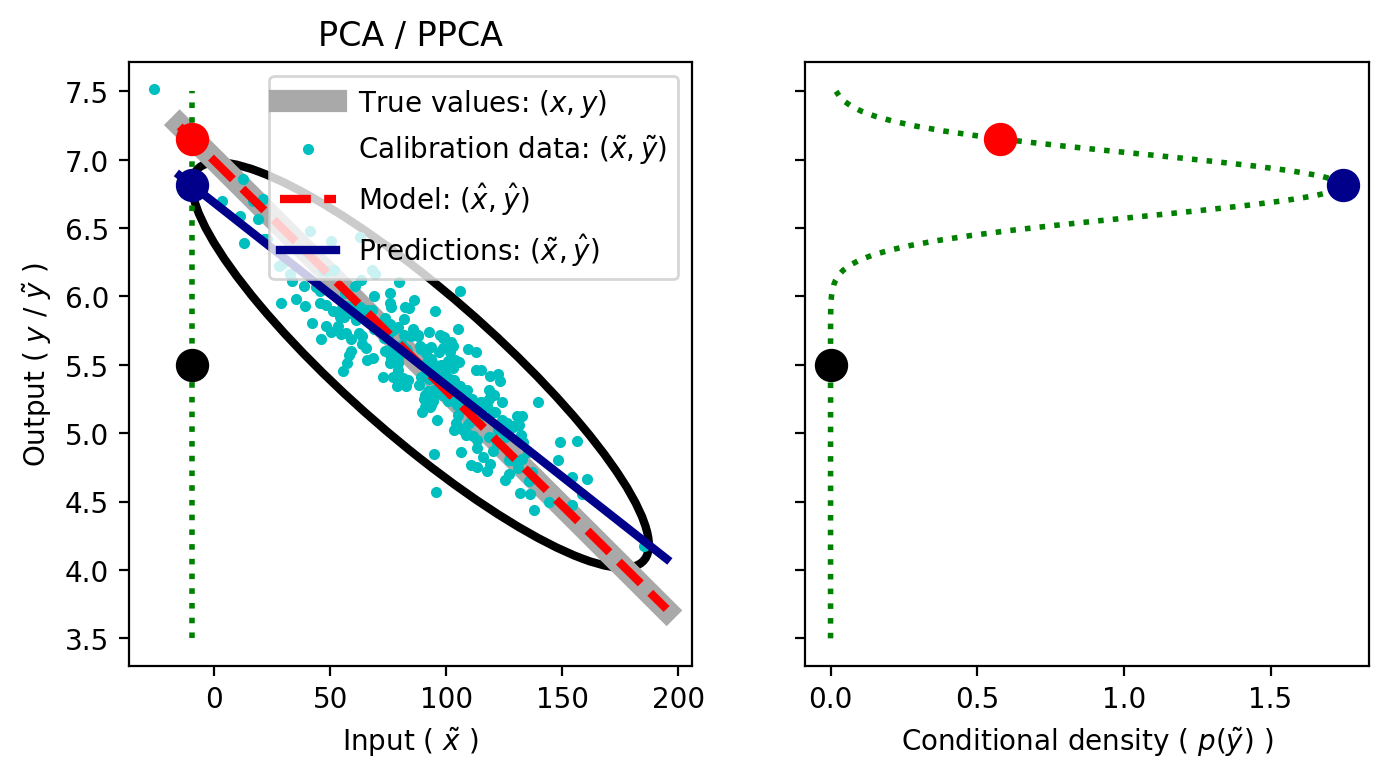

In [11]:
ell = Ellipse(xy=xy,color= 'k',
              width=lambda_[0]*j*2, height=lambda_[1]*j*2,lw=3,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('none')

fig,axs = plt.subplots(nrows=1, ncols=2,figsize=[8,4],dpi=200, sharey='row')

# Panel 1
ax = axs[0]
ax.add_artist(ell)
ax.plot( x_sim,beta[1]*x_sim+beta[0],'k-',lw=8,color='darkgrey',label='True values: $(x,y)$')
ax.plot( xtil_cal,ytil_cal,'c.',label='Calibration data: $(\~{x},\~{y})$')
ax.plot( x_sim,yhat_PCA_sim,'--',lw=3,color='red',label='Model: $(\^x,\^y)$')
ax.plot( x_sim,yhat_PPCA_sim,'-',lw=3,color='darkblue',label='Predictions: $(\~x,\^y)$')
ax.plot(x1*np.ones(2),[+3.5,+7.5],'g:',lw=2)
ax.plot(x1,zm[1],'ko',markersize=11)
ax.plot(x1,y1,'ro',markersize=11)
ax.plot(x1,mu,'o',markersize=11,color='darkblue')
ax.set_title('PCA / PPCA')
ax.set_xlabel('Input ( $\~x$ )');
ax.set_ylabel('Output ( $y$ / $\~y$ )');
ax.legend()

# Panel 2
ax = axs[1]
xx = np.linspace(+3.5,+7.5,111)
ax.plot(norm.pdf(xx, mu, sigma),xx,'g:',lw=2)
ax.plot(norm.pdf(zm[1], mu, sigma),zm[1],'ko',markersize=11)
ax.plot(norm.pdf(y1, mu, sigma),y1,'ro',markersize=11)
ax.plot(norm.pdf(mu, mu, sigma),mu,'o',markersize=11,color='darkblue')
ax.set_xlabel('Conditional density ( $p(\~y)$ )');

The PPCA-based predictions can also be interpreted as a two step procedure, which is illustrated in the next figure. First, the marginal distribution of the true values of the input variables, as estimated through PPCA, is used to replace the input measurements with the maximum a posteriori estimate of their (unknown) true values (black circle). Second, the replaced measurements are used to intersect with the model for the true values (red line). One can see that the obtained value for $y$ (red circle) matches the value obtained before by means of the ellipse (blue dot). This reveals a Bayesian interpretation of the PPCA model that is not available with standard PCA. The normal distribution for the input variable acts as a prior during prediction.

In [12]:
s1x = Sigma[0,0]-sigma_x**2
s1e = sigma_x**2
s2y = Sigma[1,1]
s2e = sigma_y**2

y1 = betahat_PCA[1]*x1+betahat_PCA[0]
x1c = (x1*s1x+zm[0]*s1e)/(s1x+s1e)
y1c = betahat_PCA[1]*x1c+betahat_PCA[0]

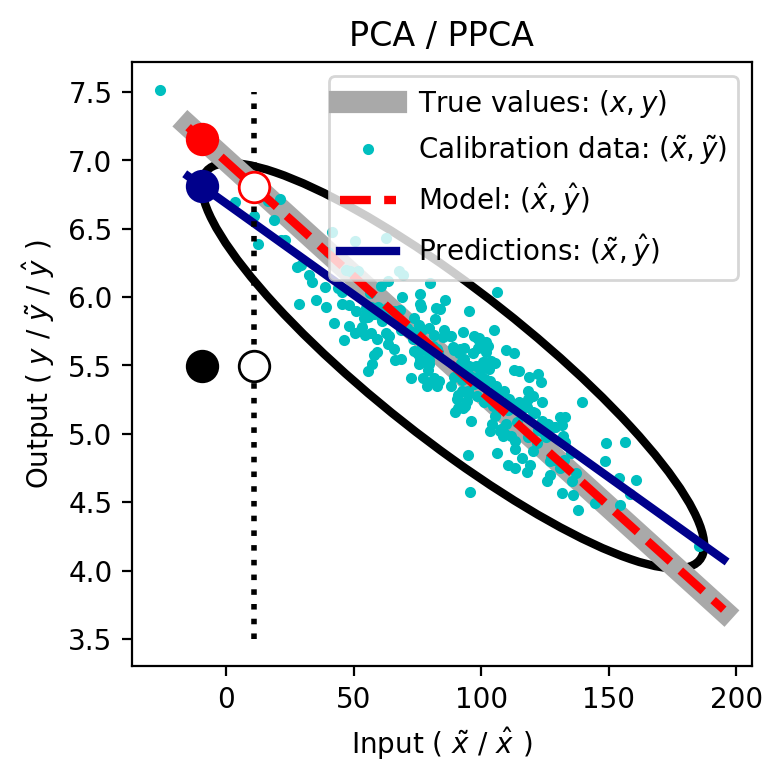

In [13]:
ell = Ellipse(xy=xy,color= 'k',
              width=lambda_[0]*j*2, height=lambda_[1]*j*2,lw=3,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('none')

fig,axs = plt.subplots(nrows=1, ncols=1,figsize=[4,4],dpi=200)
ax = axs
ax.add_artist(ell)
ax.plot( x_sim,beta[1]*x_sim+beta[0],'k-',lw=8,color='darkgrey',label='True values: $(x,y)$')
ax.plot( xtil_cal,ytil_cal,'c.',label='Calibration data: $(\~{x},\~{y})$')
ax.plot( x_sim,yhat_PCA_sim,'--',lw=3,color='red',label='Model: $(\^x,\^y)$')
ax.plot( x_sim,yhat_PPCA_sim,'-',lw=3,color='darkblue',label='Predictions: $(\~x,\^y)$')
ax.plot(x1,zm[1],'ko',markersize=11)
ax.plot(x1,y1,'ro',markersize=11)
ax.plot(x1,mu,'o',markersize=11,color='darkblue')
ax.plot(x1c*np.ones(2),[+3.5,+7.5],'k:',lw=2)
ax.plot(x1c,zm[1],'ko',markersize=11,markerfacecolor='w')
ax.plot(x1c,y1c,'ro',markersize=11,markerfacecolor='w')

ax.set_title('PCA / PPCA')
ax.set_xlabel('Input ( $\~x$ / $\^x$ )');
ax.set_ylabel('Output ( $y$ / $\~y$ / $\^y$ )');
ax.legend();

### 1.5.3. Summary

* Key to the differences between PCA- and PPCA-based predictions is that they are based on different assumptions. In PCA, the input variables are assumed to be measured perfectly during prediction even if they are assumed to have measurement errors during calibration. In PPCA, it is assumed that the distribution of the data during prediction is entirely the same as the distribution during calibration. This means the measurement error in the input is accounted for but also that the estimated distribution of the true values of the input variables is applied as a prior during prediction.

* The PPCA-based predictions will only be the same to the LR prediction in some specific cases: (a) when $K=N$ and (b) when $K=N-1$. In addition, the presence of repeated measurements -if there are any- are not accounted for. Go to [the next post](Soft-Sensing2.ipynb) to check what happens when the number of variables is larger ($K<N−1$).

## 1.6. Take home message

* PPCA-based soft-sensors deliver counter-intuitive predictions that are numerically equal to those obtained with linear regression in the bivariate case. However, these predictions can be interpreted as (a) maximum-likelihood imputations and also as (b) maximum a posteriori estimates in a Bayesian framework.

* PPCA-based soft-sensors allow to reconcile the input values with a prior distribution obtained through model calibration.

* The toy example helped illustrate that a model based on wrong assumptions (LR) can produce predictions that are equal to the predictions obtained with the correct model (PPCA). While this is a rare situation, it highlights the distinction between model inference (i.e., describing a data-generating system) and prediction (i.e, predicting unmeasured values).

## Code availability

You can find this post as a notebook on [GitLab](https://gitlab.com/krisvillez/software-sensors).

## Literature

[1] Russo, S, Li, G, Villez, K (2019). Automated model selection in principal component analysis: A new approach based on the cross-validated ignorance score. Ind Eng Chem Res, 58(30), 13448-13468. [[preprint]](https://arxiv.org/abs/1902.03293) [[publisher]](https://pubs.acs.org/doi/10.1021/acs.iecr.9b00642)

[2] [https://en.wikipedia.org/wiki/Missing_data](https://en.wikipedia.org/wiki/Missing_data)

[3] Wentzell, P. D., Andrews, D. T., Hamilton, D. C., Faber, K., & Kowalski, B. R. (1997). Maximum likelihood principal component analysis. Journal of Chemometrics, 11(4), 339-366. [[publisher]](https://doi.org/10.1002/(SICI)1099-128X(199707)11:4%3C339::AID-CEM476%3E3.0.CO;2-L)

[4] Schuermans, M., Markovsky, I., Wentzell, P. D., & Van Huffel, S. (2005). On the equivalence between total least squares and maximum likelihood PCA. Analytica Chimica Acta, 544(1-2), 254-267. [[publisher]](https://doi.org/10.1016/j.aca.2004.12.059)

[5] Nelson, P. R., Taylor, P. A., & MacGregor, J. F. (1996). Missing data methods in PCA and PLS: Score calculations with incomplete observations. Chemometrics and intelligent laboratory systems, 35(1), 45-65. [[publisher]](https://doi.org/10.1016/S0169-7439(96)00007-X)

[6] Folch-Fortuny, A., Arteaga, F., & Ferrer, A. (2015). PCA model building with missing data: New proposals and a comparative study. Chemometrics and Intelligent Laboratory Systems, 146, 77-88. [[publisher]](https://doi.org/10.1016/j.chemolab.2015.05.006)

[7] Tipping, M. E., & Bishop, C. M. (1999). Probabilistic principal component analysis. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 61(3), 611-622. [[publisher]](https://doi.org/10.1111/1467-9868.00196)

[8] Roweis, S. T. (1998). EM algorithms for PCA and SPCA. In: Advances in Neural Information Processing Systems (pp. 626-632). [[publisher]](http://papers.nips.cc/paper/1398-em-algorithms-for-pca-and-spca.pdf)